In [ ]:
import io
from datasets import load_dataset, Dataset
from torch.utils.data import DataLoader
import torch
from PIL import Image
import torchvision.transforms as trn
from tqdm import tqdm
from matplotlib.colors import ListedColormap

import torchvision
from torchcp.classification.predictors import ClusterPredictor, ClassWisePredictor, SplitPredictor
from torchcp.classification.scores import THR, APS, SAPS, RAPS
from torchcp.classification import Metrics
from torchcp.utils import fix_randomness
from torchcp.regression.predictors import ACI, CQR

In [2]:
dataset = load_dataset("parquet", data_files={'train': 'tiny_imagenet.parquet'})

Found cached dataset parquet (/root/.cache/huggingface/datasets/parquet/default-9b92332296153514/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
dataset = dataset['train']

In [5]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 100000
})

In [17]:
cal_test_split = dataset.train_test_split(test_size=0.5)

In [21]:
cal_dataset = cal_test_split['train']
test_dataset = cal_test_split['test']

In [22]:
test_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 50000
})

In [23]:
cal_dataset[0]['image'].keys()

dict_keys(['bytes', 'path'])

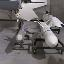

In [24]:
Image.open(io.BytesIO(cal_dataset[0]['image']['bytes']))

In [25]:
class CustomDataset:
    def __init__(self, data):
        self.data = data  # 假设data是一个字典列表，每个字典包含'image'和'label'
        self.transform = trn.Compose([
            trn.ToTensor(),
            trn.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = Image.open(io.BytesIO(item['image']['bytes'])).convert('RGB')
        image = self.transform(image)  # 假设item['image']已经被转换为可以处理的对象
        label = torch.tensor(item['label'])  # 将标签转换为Tensor
        return image, label

# 假设你的dataset变量已经初始化
cal_dataset = CustomDataset(cal_dataset)
test_dataset = CustomDataset(test_dataset)

# 创建DataLoader
cal_dataloader = DataLoader(
    cal_dataset,
    batch_size=32,  
    shuffle=True, 
    num_workers=4,  # 使用多线程读取数据（根据系统资源设置）
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=True, 
    num_workers=4,  # 使用多线程读取数据（根据系统资源设置）
)

In [26]:
model_name = 'ResNet101'
model = torchvision.models.resnet101(weights="IMAGENET1K_V1", progress=True)
model_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(model_device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [27]:
alpha = 0.1
print(f"Experiment--Data : I, Model : {model_name}, Score : THR, Predictor : SplitPredictor, Alpha : {alpha}")
score_function = THR()
predictor = ClusterPredictor(score_function, model)
print(f"The size of calibration set is {len(cal_dataset)}.")
predictor.calibrate(cal_dataloader, alpha)
predictor.evaluate(test_dataloader)

Experiment--Data : I, Model : ResNet101, Score : THR, Predictor : SplitPredictor, Alpha : 0.1
The size of calibration set is 100000.


/data/lab/STA303-Assignment04/TorchCP/torchcp/classification/predictors/cluster.py:79: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=int(self.__num_clusters), n_init=10).fit(X=embeddings.detach().cpu().numpy(),


{'Coverage_rate': 0.04754, 'Average_size': 60.23354}

In [28]:
predictors = [SplitPredictor, ClassWisePredictor, ClusterPredictor]
score_functions = [THR(),  APS(), RAPS(1, 0), SAPS(0.2)]
for score in score_functions: 
    for class_predictor in predictors:
        predictor = class_predictor(score, model)
        predictor.calibrate(cal_dataloader, alpha)
        print(f"Experiment--Data : ImageNet, Model : {model_name}, Score : {score.__class__.__name__}, Predictor : {predictor.__class__.__name__}, Alpha : {alpha}")
        print(predictor.evaluate(test_dataloader))

Experiment--Data : ImageNet, Model : ResNet101, Score : THR, Predictor : SplitPredictor, Alpha : 0.1
{'Coverage_rate': 0.04754, 'Average_size': 60.2335}
Experiment--Data : ImageNet, Model : ResNet101, Score : THR, Predictor : ClassWisePredictor, Alpha : 0.1


/data/lab/STA303-Assignment04/TorchCP/torchcp/classification/predictors/split.py:61: UserWarning: The number of scores is 0, which is a invalid scores. To avoid program crash, the threshold is set as torch.inf.
  warnings.warn(


{'Coverage_rate': 0.04754, 'Average_size': 809.90622}


/data/lab/STA303-Assignment04/TorchCP/torchcp/classification/predictors/cluster.py:79: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=int(self.__num_clusters), n_init=10).fit(X=embeddings.detach().cpu().numpy(),


Experiment--Data : ImageNet, Model : ResNet101, Score : THR, Predictor : ClusterPredictor, Alpha : 0.1
{'Coverage_rate': 0.04754, 'Average_size': 60.2335}
Experiment--Data : ImageNet, Model : ResNet101, Score : APS, Predictor : SplitPredictor, Alpha : 0.1
{'Coverage_rate': 0.35788, 'Average_size': 368.80458}
Experiment--Data : ImageNet, Model : ResNet101, Score : APS, Predictor : ClassWisePredictor, Alpha : 0.1


/data/lab/STA303-Assignment04/TorchCP/torchcp/classification/predictors/split.py:61: UserWarning: The number of scores is 0, which is a invalid scores. To avoid program crash, the threshold is set as torch.inf.
  warnings.warn(


{'Coverage_rate': 0.76548, 'Average_size': 952.98936}
Experiment--Data : ImageNet, Model : ResNet101, Score : APS, Predictor : ClusterPredictor, Alpha : 0.1
{'Coverage_rate': 0.58412, 'Average_size': 413.45044}
Experiment--Data : ImageNet, Model : ResNet101, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.1
{'Coverage_rate': 0.89896, 'Average_size': 929.0014}


/data/lab/STA303-Assignment04/TorchCP/torchcp/classification/predictors/split.py:61: UserWarning: The number of scores is 0, which is a invalid scores. To avoid program crash, the threshold is set as torch.inf.
  warnings.warn(


Experiment--Data : ImageNet, Model : ResNet101, Score : RAPS, Predictor : ClassWisePredictor, Alpha : 0.1
{'Coverage_rate': 0.89856, 'Average_size': 968.29246}
Experiment--Data : ImageNet, Model : ResNet101, Score : RAPS, Predictor : ClusterPredictor, Alpha : 0.1
{'Coverage_rate': 0.90288, 'Average_size': 948.75098}
Experiment--Data : ImageNet, Model : ResNet101, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.1
{'Coverage_rate': 0.8998, 'Average_size': 929.5803}
Experiment--Data : ImageNet, Model : ResNet101, Score : SAPS, Predictor : ClassWisePredictor, Alpha : 0.1


/data/lab/STA303-Assignment04/TorchCP/torchcp/classification/predictors/split.py:61: UserWarning: The number of scores is 0, which is a invalid scores. To avoid program crash, the threshold is set as torch.inf.
  warnings.warn(


{'Coverage_rate': 0.89832, 'Average_size': 968.29782}
Experiment--Data : ImageNet, Model : ResNet101, Score : SAPS, Predictor : ClusterPredictor, Alpha : 0.1
{'Coverage_rate': 0.89586, 'Average_size': 673.7464}


In [144]:
predictor = SplitPredictor(RAPS(1, 0), model)
predictor.calibrate(cal_dataloader, alpha)

In [145]:
print(len(test_dataset))

50000


In [146]:
matrix = np.zeros((50000, 1000))
avg_num = 0

In [147]:
id = 0
for batch_idx, (data, target) in tqdm(enumerate(test_dataloader)):
    prediction_Intervals = predictor.predict(data)
    
    for i in range(len(prediction_Intervals)):
        pre_i = prediction_Intervals[i]
        num = len(pre_i)
        avg_num += num
        for j in range(1000):
            matrix[id][j] = 1 if j in pre_i else 0
        matrix[id][target[i].item()] = 2
        id +=1 

1563it [04:47,  5.43it/s]


In [148]:
print(avg_num/50000)

929.00138


In [ ]:
# 创建figure对象，这里不特别设定figure尺寸
fig, ax = plt.subplots()

# 调整热力图的大小，这里假设要显示为20x10英寸
width_inches = 200000
height_inches = 20
ax.imshow(matrix, aspect='auto', interpolation='nearest')  # 'aspect'参数保持纵横比

# 调整axes的尺寸以匹配figure大小，这里需要知道原图的宽高比
# 假设原始数据矩阵是一个正方形矩阵
ratio = matrix.shape[0] / matrix.shape[1]
ax.set_aspect(ratio * (height_inches/width_inches))

# 添加颜色条，并确保它也随着热力图缩放
cbar = fig.colorbar(ax.images[0], ax=ax, fraction=0.046, pad=0.04)  # 可根据实际情况微调fraction和pad值

# 显示图形
plt.show()

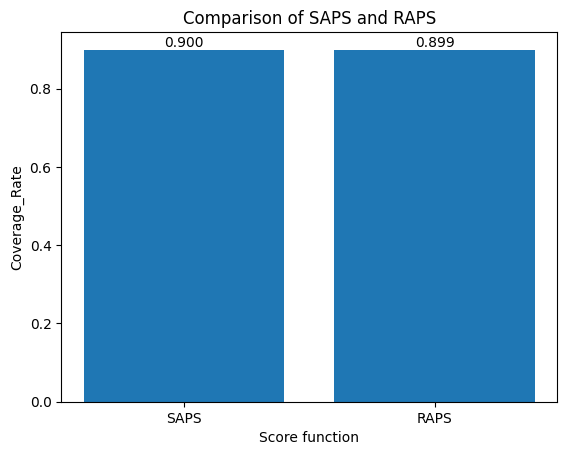

In [140]:
import matplotlib.pyplot as plt

# 假设您有两个数值
value1 = 0.8998
value2 = 0.89896
categories = ['SAPS', 'RAPS']
values = [value1, value2]

# 绘制柱状图
bars = plt.bar(categories, values)

# 遍历每一个柱子并标注其上方的值
for bar in bars:
    height = bar.get_height()
    # 根据柱子中心位置加上适当的偏移量来定位文本
    plt.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                 ha='center', va='bottom', fontsize=10, color='black')

plt.title('Comparison of SAPS and RAPS')
plt.xlabel('Score function')
plt.ylabel('Coverage_Rate')

# 显示图形
plt.show()

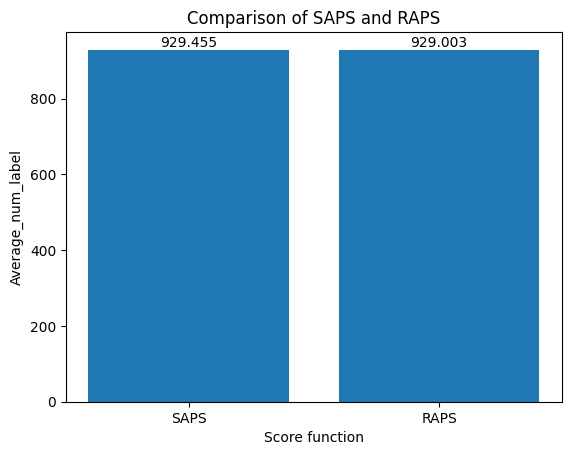

In [149]:
import matplotlib.pyplot as plt

# 假设您有两个数值
value1 = 929.455
value2 = 929.003
categories = ['SAPS', 'RAPS']
values = [value1, value2]

# 绘制柱状图
bars = plt.bar(categories, values)

# 遍历每一个柱子并标注其上方的值
for bar in bars:
    height = bar.get_height()
    # 根据柱子中心位置加上适当的偏移量来定位文本
    plt.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                 ha='center', va='bottom', fontsize=10, color='black')

plt.title('Comparison of SAPS and RAPS')
plt.xlabel('Score function')
plt.ylabel('Average_num_label')

# 显示图形
plt.show()